In [168]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import json
import os
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

In [194]:
# Load the JSON file
def load_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data

# Preprocess images and camera poses
def preprocess_nerf_data(data, image_dir, image_size):
    images = []
    poses = []
    
    for frame in data['frames']:
        # Load and preprocess the image
        file_path = os.path.join(image_dir, os.path.normpath(frame['file_path']).split('/')[-1] + '.png')
        image = Image.open(file_path).resize(image_size)
        image = np.array(image).astype(np.float32) / 255.0  # Normalize to [0, 1]
        images.append(image)

        # Extract the transformation matrix (pose)
        transform_matrix = np.array(frame['transform_matrix'], dtype=np.float32)
        poses.append(transform_matrix)
    
    # Convert lists to numpy arrays
    images = np.stack(images, axis=0)  # Shape: (num_images, height, width, channels)
    poses = np.stack(poses, axis=0)    # Shape: (num_images, 4, 4)
    
    # Convert to PyTorch tensors
    images = torch.tensor(images).permute(0, 3, 1, 2)  # Convert to shape (N, C, H, W) for PyTorch
    poses = torch.tensor(poses)
    
    return images, poses

In [195]:
# Load JSON data
json_path = './lego/transforms_train.json'
data = load_json(json_path)

# Image directory and size
image_dir = 'lego'  # Replace with your actual directory containing images
image_size = (400, 400)  # Adjust this according to your model input size

# Preprocess the images and camera poses
images, poses = preprocess_nerf_data(data, image_dir, image_size)

# Now images and poses are ready to be fed into your NeRF PyTorch model
print(f"Processed {len(images)} images and {len(poses)} camera poses.")

Processed 100 images and 100 camera poses.


In [122]:
# helper functions
def calculate_focal_length(image_width=400, camera_angle_x=0.6911112070083618):
    # Calculate the focal length using the camera_angle_x (horizontal FOV in radians)
    focal_length = image_width / (2 * math.tan(camera_angle_x / 2))
    return focal_length

def get_rays(H, W, focal, c2w):
    """
    Generate ray origins and directions from a camera pose matrix.
    
    Args:
    - H, W: Image height and width
    - focal: Focal length of the camera
    - c2w: Camera-to-world transformation matrix of shape (4, 4)
    
    Returns:
    - rays_o: Ray origins (camera origin), shape (H*W, 3)
    - rays_d: Ray directions, shape (H*W, 3)
    """
    i, j = torch.meshgrid(torch.linspace(0, W - 1, W), torch.linspace(0, H - 1, H))
    i = i.t()
    j = j.t()
    
    # Normalize pixel coordinates
    dirs = torch.stack([(i - W * 0.5) / focal, -(j - H * 0.5) / focal, -torch.ones_like(i)], -1)  # [H, W, 3]
    
    # Apply camera-to-world transformations to get ray directions in world space
    rays_d = torch.sum(dirs[..., None, :] * c2w[:3, :3], -1)  # [H, W, 3]
    
    # All rays originate from the camera center (c2w[:3, 3])
    rays_o = c2w[:3, 3].expand(rays_d.shape)  # [H, W, 3]
    
    return rays_o, rays_d

# Dataset class for NeRF data
class NeRFDataset(Dataset):
    def __init__(self, images, poses):
        self.images = images
        self.poses = poses
        self.focal = calculate_focal_length()
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        pose = self.poses[idx]
        if pose.shape != (4, 4):
            raise ValueError(f"Pose should have shape (4, 4), but got {pose.shape}")
        # Get ray origins and directions
        H, W = image.shape[-2:]
        rays_o, rays_d = get_rays(H, W, self.focal, pose)
        
        #reshape rays
        rays_o = rays_o.reshape(-1, 3)
        rays_d = rays_d.reshape(-1, 3)
        return rays_o, rays_d

# NeRF Model Definition
class NeRF(nn.Module):
    def __init__(self, input_dim=3, dir_dim=3, hidden_dim=256, output_dim=4):
        super(NeRF, self).__init__()
        
        # First part: Fully connected layers to process the (x, y, z) coordinates
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        
        # Second part: Linear layers for the (dx, dy, dz) viewing direction
        self.dir_fc1 = nn.Linear(dir_dim + hidden_dim, hidden_dim // 2)
        self.dir_fc2 = nn.Linear(hidden_dim // 2, hidden_dim // 2)
        
        # Output layer
        self.fc_out_color = nn.Linear(hidden_dim // 2, 3)  # Output RGB
        self.fc_out_density = nn.Linear(hidden_dim, 1)     # Output density

    def forward(self, x, direction):
        # Process the 3D spatial location (x, y, z)
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        h = F.relu(self.fc4(h))
        
        # Output density (sigma)
        density = self.fc_out_density(h)  # Scalar value for density

        # Concatenate direction with hidden representation of the location
        h_dir = torch.cat([h, direction], dim=-1)
        
        # Process the direction vector with location features
        h_dir = F.relu(self.dir_fc1(h_dir))
        h_dir = F.relu(self.dir_fc2(h_dir))

        # Output RGB color
        color = torch.sigmoid(self.fc_out_color(h_dir))  # Output 3-channel RGB (values between 0 and 1)

        # Return color and density
        return torch.cat([color, density], dim=-1)  # Shape: (batch_size, 4)

In [143]:
# Prepare dataset and dataloader
nerf_dataset = NeRFDataset(images, poses)
data_loader = DataLoader(nerf_dataset, batch_size=1, shuffle=True)

# Initialize the NeRF model
nerf_model = NeRF()

# define optimizer
optimizer = torch.optim.Adam(nerf_model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    for rays_o, rays_d in tqdm(data_loader):
        ground_truth_rgb = rays_o

        # get model output
        output = nerf_model(rays_o, rays_d)

        # predicted rgb
        pred_rgb = output[..., :3]

        # ground truth rgb
        ground_truth_rgb = ground_truth_rgb.reshape(-1, 3)

        # calculate loss
        loss = F.mse_loss(pred_rgb, ground_truth_rgb)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

print("Training complete!")

Epoch 1/1


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\aksha\AppData\Local\Temp\ipykernel_26676\876500406.py:30: UserWarning: Using a target size (torch.Size([160000, 3])) that is different to the input size (torch.Size([1, 160000, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(pred_rgb, ground_truth_rgb)
100%|██████████| 100/100 [01:51<00:00,  1.12s/it]

Epoch 1/1, Loss: 3.483819007873535
Training complete!


In [160]:
# Load Validation data
val_json_path = './lego/transforms_val.json'
val_data = load_json(val_json_path)

# Image directory and size
image_dir = 'lego'  # Replace with your actual directory containing images
image_size = (400, 400)  # Adjust this according to your model input size

# Preprocess the images and camera poses
val_images, val_poses = preprocess_nerf_data(val_data, image_dir, image_size)

# Now images and poses are ready to be fed into your NeRF PyTorch model
print(f"Processed {len(val_images)} images and {len(val_poses)} camera poses.")

Processed 100 images and 100 camera poses.


In [163]:
def render_novel_view(nerf_model, H, W, pose, focal=calculate_focal_length()):
    """
    Renders a novel view by generating rays for a new camera pose and passing them through the NeRF model.
    """
    # Generate rays for the camera pose
    rays_o, rays_d = get_rays(H, W, focal, pose)

    # Flatten rays to shape (H*W, 3)
    rays_o = rays_o.reshape(-1, 3)
    rays_d = rays_d.reshape(-1, 3)

    # Pass the rays through the trained NeRF model
    with torch.no_grad():  # No need to compute gradients during rendering
        model_output = nerf_model(rays_o, rays_d)

    # Extract predicted RGB values
    predicted_rgb = model_output[..., :3]

    # Reshape to (H, W, 3) to get the final image
    rendered_image = predicted_rgb.reshape(H, W, 3).cpu().numpy()

    return rendered_image

In [216]:
output_1 = render_novel_view(nerf_model, 400, 400, poses[0])
image_rgb = images[0][:3, :, :].permute(1, 2, 0)

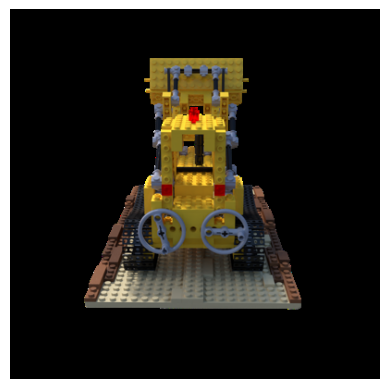

In [217]:
plt.imshow(image_rgb)
plt.axis('off')
plt.show()